#*Application of machine learning methods to identify and categorize radio pulsar signal candidates*


##Import Libraries and Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving HTRU_2.csv to HTRU_2.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


##Dataset Loading


   Mean_of_IP   SD_of_IP  EK_of_IP  Skew_of_IP  Mean_of_DM_SNR  SD_of_DM_SNR  \
0  140.562500  55.683782 -0.234571   -0.699648        3.199833     19.110426   
1  102.507812  58.882430  0.465318   -0.515088        1.677258     14.860146   
2  103.015625  39.341649  0.323328    1.051164        3.121237     21.744669   
3  136.750000  57.178449 -0.068415   -0.636238        3.642977     20.959280   
4   88.726562  40.672225  0.600866    1.123492        1.178930     11.468720   

   EK_of_DM_SNR  Skew_of_DM_SNR  target_class  
0      7.975532       74.242225             0  
1     10.576487      127.393580             0  
2      7.735822       63.171909             0  
3      6.896499       53.593661             0  
4     14.269573      252.567306             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mean_of_IP      17898 non-nu

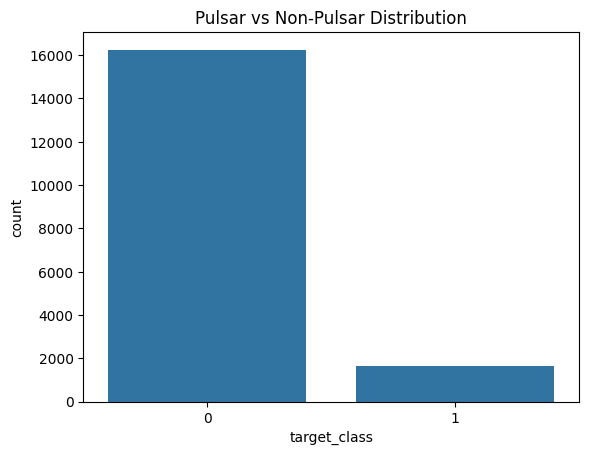

In [ ]:
data = pd.read_csv("HTRU_2.csv", header=None)
data.columns = [
    "Mean_of_IP", "SD_of_IP", "EK_of_IP", "Skew_of_IP",
    "Mean_of_DM_SNR", "SD_of_DM_SNR", "EK_of_DM_SNR", "Skew_of_DM_SNR",
    "target_class"
]

# Quick overview
print(data.head())
print(data.info())
print(data['target_class'].value_counts())

# Visualize target distribution
sns.countplot(x='target_class', data=data)
plt.title("Pulsar vs Non-Pulsar Distribution")
plt.show()

##Dataset Preprocessing

In [ ]:
X = data.drop(columns='target_class')
y = data['target_class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

#Model Training

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True,random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print("Accuracy:", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

=== Logistic Regression ===
Accuracy: 0.979608938547486
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.94      0.83      0.88       328

    accuracy                           0.98      3580
   macro avg       0.96      0.91      0.94      3580
weighted avg       0.98      0.98      0.98      3580

=== Random Forest ===
Accuracy: 0.982122905027933
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.93      0.87      0.90       328

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580

=== SVM ===
Accuracy: 0.9807262569832402
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.95      0.84      0.89       328

    accuracy                       

##Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("=== Random Forest (Tuned) ===")
print("Accuracy:", best_rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
=== Random Forest (Tuned) ===
Accuracy: 0.9807262569832402
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.92      0.86      0.89       328

    accuracy                           0.98      3580
   macro avg       0.95      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],       # 'l1' or 'elasticnet' may require solver='saga'
    'solver': ['lbfgs']      # compatible with 'l2'
}

# Grid search
grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='f1'  # or 'accuracy'
)

grid_lr.fit(X_train, y_train)

# Best parameters
print("Best Logistic Regression Parameters:", grid_lr.best_params_)

# Evaluate tuned model
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print("=== Logistic Regression (Tuned) ===")
print("Accuracy:", best_lr.score(X_test, y_test))
print(classification_report(y_test, y_pred_lr))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
=== Logistic Regression (Tuned) ===
Accuracy: 0.9798882681564246
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.95      0.83      0.88       328

    accuracy                           0.98      3580
   macro avg       0.97      0.91      0.94      3580
weighted avg       0.98      0.98      0.98      3580



In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],       # Regularization parameter
    'gamma': ['scale', 'auto'],   # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Different kernels
}

# Grid search for SVM
grid_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='f1'  # or 'accuracy'
)

grid_svm.fit(X_train, y_train)

# Best parameters
print("Best SVM Parameters:", grid_svm.best_params_)

# Evaluate tuned SVM
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]

print("=== SVM (Tuned) ===")
print("Accuracy:", best_svm.score(X_test, y_test))
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
=== SVM (Tuned) ===
Accuracy: 0.9810055865921787
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.94      0.85      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



## 🧪 Testing and Results

After training the models on the training dataset, we evaluated their performance on the **test set** to measure how well they generalize to unseen data.

### Evaluation Metrics Used
- **Accuracy:** Measures the overall correctness of the model’s predictions.  
- **Precision:** Indicates how many of the predicted positives are actually positive.  
- **Recall:** Shows how many of the actual positives were correctly identified.  
- **F1-Score:** The harmonic mean of precision and recall, providing a balance between them.  
- **Confusion Matrix:** Displays the number of correct and incorrect predictions in each class.  
- **ROC Curve & AUC Score:** Visualize the trade-off between true positive and false positive rates.

The results show that:
- **Logistic Regression** performs well as a baseline model.  
- **Random Forest** achieves higher accuracy and recall, indicating better classification power and generalization.  

The confusion matrix and ROC curve below illustrate the performance differences between both models.


##Confusion Matrix

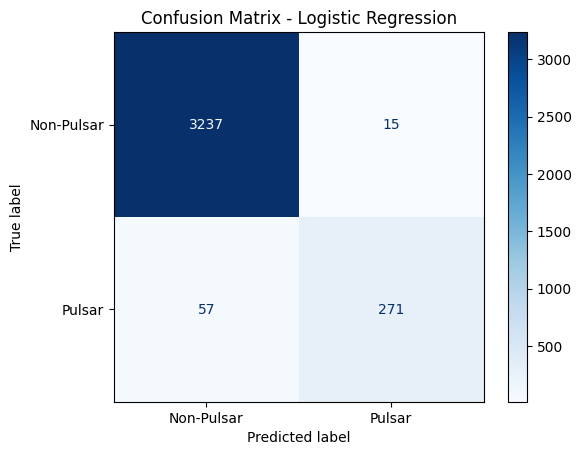

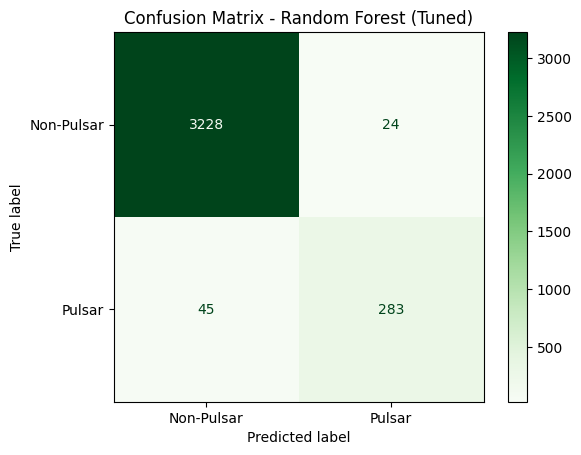

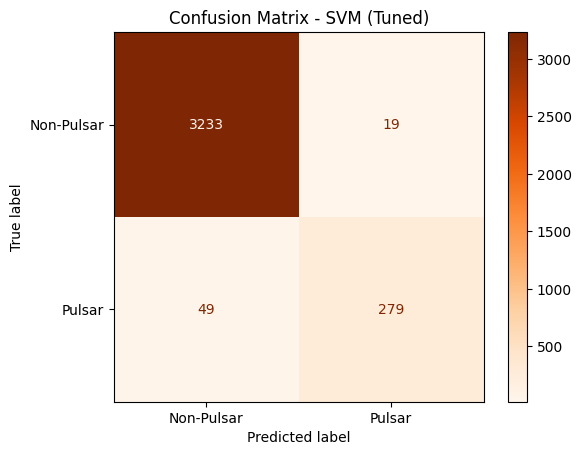

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Non-Pulsar', 'Pulsar'])
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix for Random Forest (Tuned)
cm_rf = confusion_matrix(y_test, y_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Non-Pulsar', 'Pulsar'])
disp_rf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.show()

# Confusion Matrix for SVM (Tuned)
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Non-Pulsar', 'Pulsar'])
disp_svm.plot(cmap='Oranges')
plt.title("Confusion Matrix - SVM (Tuned)")
plt.show()


##Feature Importance

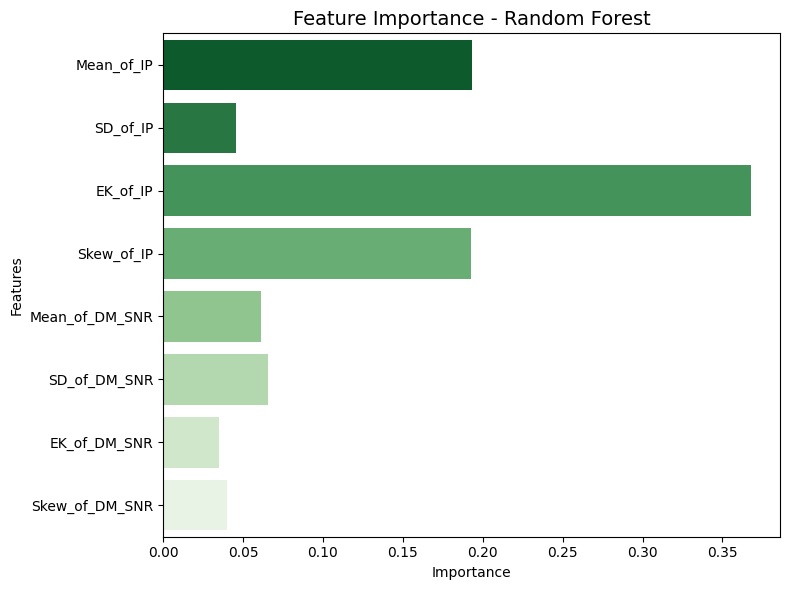

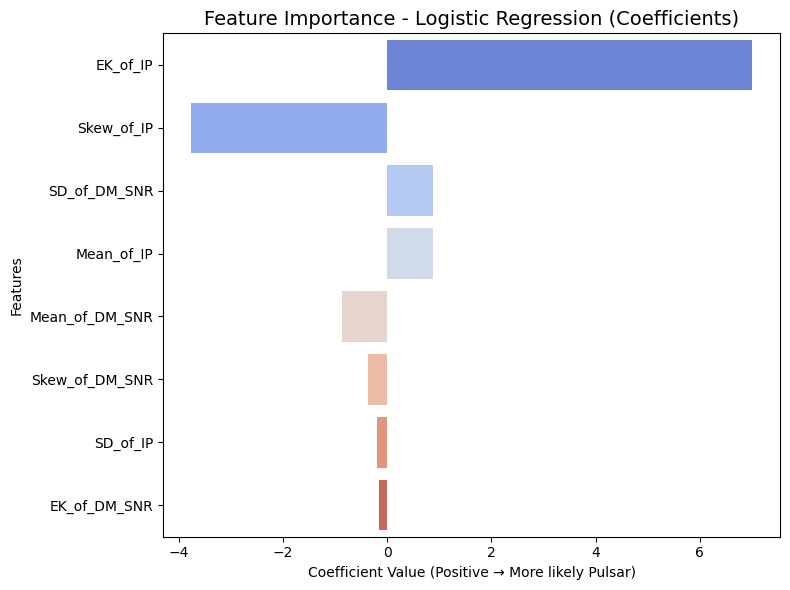

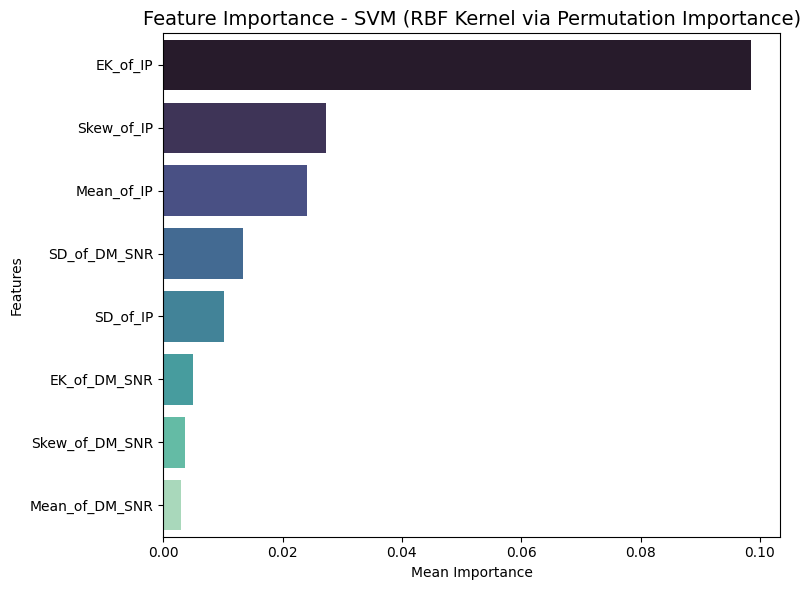

In [ ]:
# --- Feature Importance for Random Forest, Logistic Regression, and SVM (RBF) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

# ------------------- RANDOM FOREST -------------------
importances_rf = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
sns.barplot(x=importances_rf, y=features, hue = features,palette='Greens_r', legend = False)
plt.title("Feature Importance - Random Forest", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ------------------- LOGISTIC REGRESSION -------------------
coefficients_lr = best_lr.coef_[0]  # For binary classification
sorted_idx_lr = np.argsort(np.abs(coefficients_lr))[::-1]
sorted_features_lr = features[sorted_idx_lr]
sorted_coefficients_lr = coefficients_lr[sorted_idx_lr]

plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_coefficients_lr, y=sorted_features_lr, hue =sorted_features_lr, palette='coolwarm', legend = False)
plt.title("Feature Importance - Logistic Regression (Coefficients)", fontsize=14)
plt.xlabel("Coefficient Value (Positive → More likely Pulsar)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ------------------- SVM (RBF Kernel) using Permutation Importance -------------------
result_svm = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_svm = result_svm.importances_mean

sorted_idx_svm = np.argsort(importances_svm)[::-1]
sorted_features_svm = features[sorted_idx_svm]
sorted_importances_svm = importances_svm[sorted_idx_svm]

plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_importances_svm, y=sorted_features_svm, hue=sorted_features_svm, palette='mako',legend=False)
plt.title("Feature Importance - SVM (RBF Kernel via Permutation Importance)", fontsize=14)
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


##ROC Curve

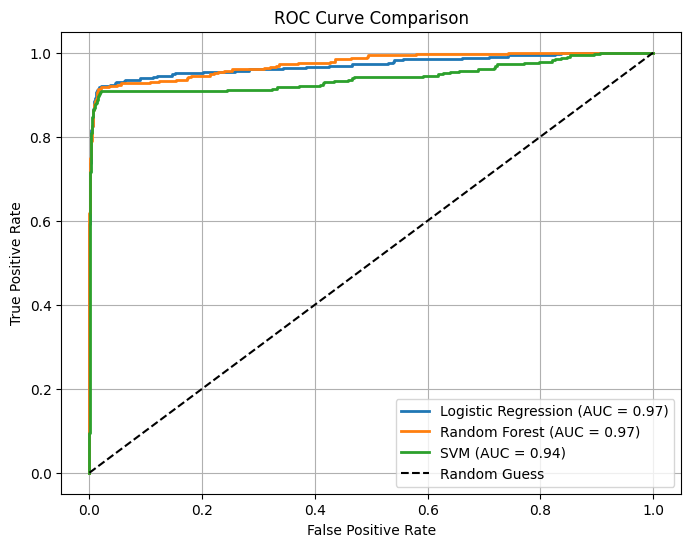

AUC Scores:
Logistic Regression: 0.971
Random Forest:       0.975
SVM:                 0.941


In [ ]:
# --- ROC Curve Comparison for Logistic Regression, Random Forest, and SVM ---

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Predict probabilities ---
# Logistic Regression
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

# Random Forest
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# SVM (use probability=True in SVC)
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]

# --- Compute ROC curve and AUC for each model ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_svm = roc_auc_score(y_test, y_prob_svm)

# --- Plot ROC curves ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# --- Graph styling ---
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# --- Print AUC values ---
print("AUC Scores:")
print(f"Logistic Regression: {auc_lr:.3f}")
print(f"Random Forest:       {auc_rf:.3f}")
print(f"SVM:                 {auc_svm:.3f}")


##PCA Visualization

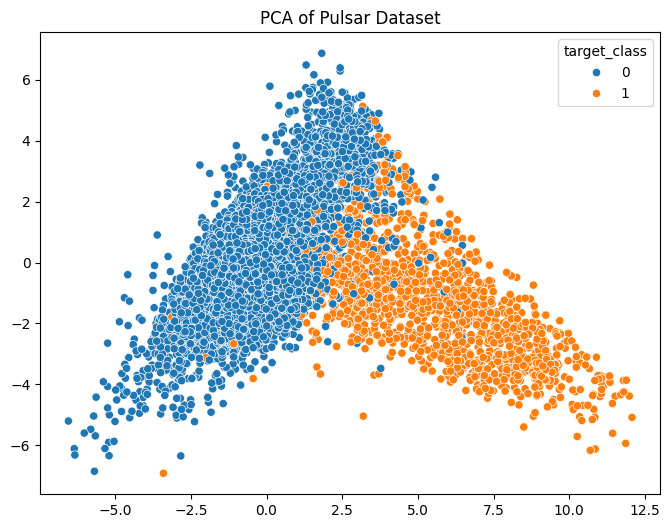

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA of Pulsar Dataset")
plt.show()

##K-Means clustering on positive class only

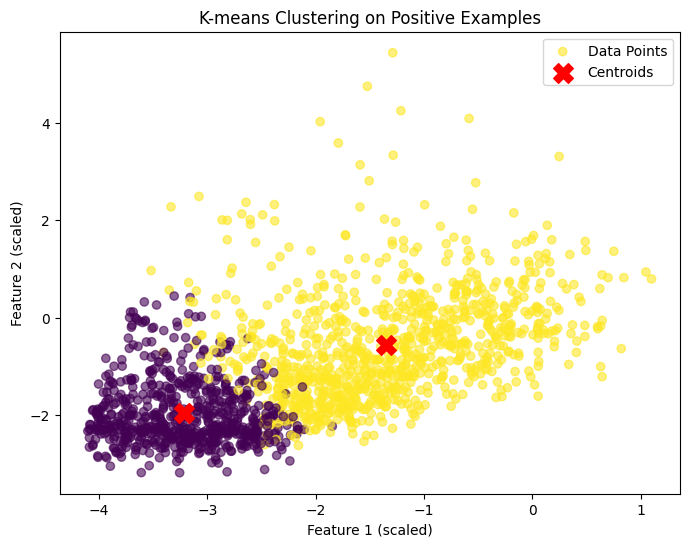

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select positive examples only
X_pos = X_scaled[y==1]

# Fit K-means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pos)

# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pos[:,0], X_pos[:,1], c=clusters, cmap='viridis', label='Data Points', alpha=0.6)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=200, label='Centroids')

plt.title("K-means Clustering on Positive Examples")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()


In [ ]:
import joblib
joblib.dump(best_rf, "best_rf_model.pkl")

['best_rf_model.pkl']

## **Project Summary**

### **Dataset Details**
The dataset consists of **8 numerical features** representing radio signal statistics —  
Mean, Standard Deviation, Excess Kurtosis, and Skewness —  
derived from the **High Time Resolution Universe (HTRU2)** survey.

Each record is labeled as either:
- **1 → Pulsar (Positive Class)**
- **0 → Non-Pulsar (Negative Class)**

The dataset was split into **70% training** and **30% testing** sets for model evaluation.

---

###  **Preprocessing Steps**
- Verified and handled missing values (none detected)  
- Standardized all features using `StandardScaler`  
- Applied **Stratified Train–Test Split** to maintain class ratio  

---

### **Algorithms Used**
1. **Logistic Regression** – A baseline linear classifier offering interpretability and quick training.  
2. **Support Vector Machine (SVM, RBF Kernel)** – Captures non-linear patterns and provides strong margin-based separation.  
3. **Random Forest Classifier** – An ensemble of decision trees that reduces overfitting and handles noisy data effectively.  

---

### **Evaluation Metrics**
Model performance was assessed using:
- **Accuracy** – overall prediction correctness  
- **Precision, Recall, and F1-score** – to evaluate balance between false positives and false negatives  
- **ROC–AUC Curve** – to visualize classification confidence  
- **Confusion Matrix** – for detailed performance analysis  

---

### **Key Results**

| Model | Accuracy | Precision | Recall | F1-score |
|:------|:----------:|:----------:|:--------:|:----------:|
| Logistic Regression | 97.99% | 0.95 | 0.83 | 0.88 |
| SVM (RBF Kernel) | **98.10%** | 0.94 | 0.85 | 0.89 |
| Random Forest | 98.07% | 0.92 | **0.86** | **0.89** |

- **SVM (RBF Kernel)** achieved the **highest overall accuracy** and balanced performance.  
- **Random Forest** demonstrated slightly better **recall**, making it ideal for identifying rare pulsar instances.  
- **Logistic Regression** performed well but was less effective under class imbalance.  

---

### **Conclusion**
All three models performed exceptionally well on the pulsar classification task.  
Among them, **SVM (RBF Kernel)** demonstrated the best generalization, while **Random Forest** excelled in recall —  
crucial for detecting true pulsars.  
This confirms that non-linear models outperform simpler linear approaches for complex astronomical signal data.

---
